In [1]:
print("Hello world lets get started with anomaly detection. Excited!!!")

Hello world lets get started with anomaly detection. Excited!!!


In [2]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

print("Packages imported")

Packages imported


In [ ]:

IMG_SIZE = 224 #based on resnet image dimensions
REPEATS = 15   # will repeat the good image 15 times to store its features in the memory. This is not ideally correct but implemented it for a POC. Ideally using 60-100 images here would do the work.
LAYER_NAMES = ["conv3_block4_out", "conv4_block6_out"] 


In [4]:
#loading a pretrained resnet50 and will use its convolutional layers to extract features
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
# Freezing the weights because we dont want the model to learn but only to extract features
base_model.trainable = False 
# Extracting the convolutional layer.
outputs = [base_model.get_layer(name).output for name in LAYER_NAMES]
# Creating a new model with the extracted layers which will be used to output multiple feature maps.
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)



In [63]:

# Function to load images for processing
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

def extract_patches(img):
    feats = model(np.expand_dims(img, axis=0)) # converting (224, 224, 3) to (1, 224, 224, 3)
    
    resized_feats = []
    # print(feats[0].shape[1], feats[0].shape[2]) # 0 for 28 x 28, 1 for 14 x 14
    target_h, target_w = feats[0].shape[1], feats[0].shape[2]

    for f in feats:
        # Resize feature map to highest resolution 28 x 28 
        if f.shape[1] != target_h or f.shape[2] != target_w:
            f = tf.image.resize(f, (target_h, target_w), method="bilinear") #bilinear interpolation to smoothen the resize 

        resized_feats.append(f)

    # Concatenate channels (NOT patches) 512 + 1024 -> 1536
    fused = tf.concat(resized_feats, axis=-1)

    # Flatten to patches 28 x 28 to 784
    patches = tf.reshape(fused, (-1, fused.shape[-1]))
    # print(patches.shape) # (784, 1536)

    return patches.numpy()




In [100]:
# Build memory to store features of a good pcb
def build_memory(good_img_path):
    img = load_image(good_img_path)
    memory = []

    for _ in range(REPEATS): # Repeating 15 times of the same image. Ideally we will use 60-100 different images.
        patches = extract_patches(img) #getting features of good pcb
        memory.append(patches) 
        #(784, 1536) 0
        #(784, 1536) 1
        # ...
        #(784, 1536) 14

    # print(len(memory)) #15
    memory = np.vstack(memory) #(11760, 1536)
    # print(memory.shape)
    return memory



In [101]:
# Get an anomaly score/distance using k nearest neighbour,  using only 1 neighbour as we only want distance between the patches.

def anomaly_score(memory, test_img_path):
    img = load_image(test_img_path)
    test_patches = extract_patches(img)

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(memory)

    distances, _ = nn.kneighbors(test_patches) # will return (distance, patch_index). But we only need distance
    score = distances.mean() #averaging the distance to get the overall image score

    return score, distances.reshape(-1) 



In [102]:

def visualize_heatmap(distances):
    h = w = int(np.sqrt(len(distances))) # 28 = 28 = sqrt(784) 
    heatmap = distances.reshape(h, w)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8) #normalize heatmap values (0,1) 

    return heatmap




In [130]:
#Draw the heatmap
def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap), cv2.COLORMAP_HOT
    )

    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0) #Overlaying heatmap overe normal img, 60% original , 40% heatmap
    return overlay


In [131]:
#display image
def load_image_for_display(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0


Anomaly Score: 2.787074749110913


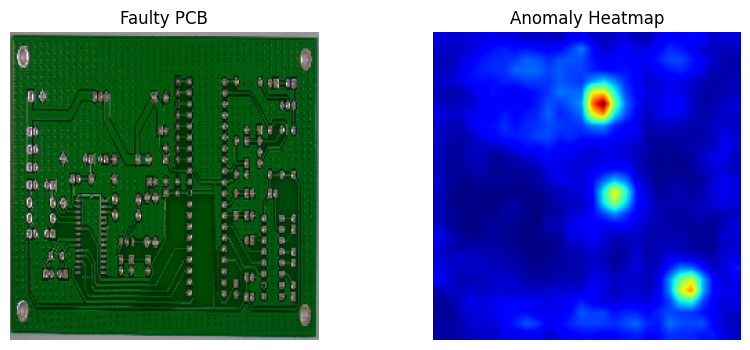

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

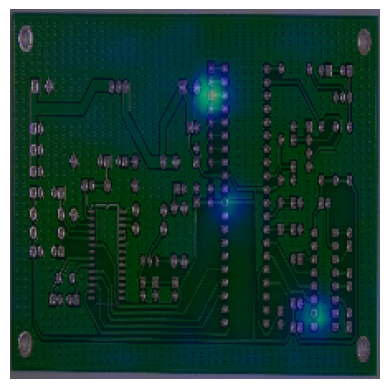

In [ ]:

#loading images
GOOD_PCB = "images/good_pcb.jpg" #golden PCB

FAULTY_PCB = "images/01_missing_hole_01.jpg" #Faulty PCB
# FAULTY_PCB = "images/01_mouse_bite_01.jpg"
# FAULTY_PCB = "images/01_open_circuit_01.jpg"
# FAULTY_PCB = "images/01_short_01.jpg"
# FAULTY_PCB = "images/01_spurious_copper_05.jpg"


memory = build_memory(GOOD_PCB)
score, distances = anomaly_score(memory, FAULTY_PCB)

heatmap = visualize_heatmap(distances)

print("Anomaly Score:", score)
#ploting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(load_image_for_display(FAULTY_PCB))
plt.title("Faulty PCB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Anomaly Heatmap")
plt.axis("off")

plt.show()

overlay = overlay_heatmap(FAULTY_PCB, heatmap)
plt.imshow(overlay)
plt.axis("off")
